In [5]:
! pip install ucimlrepo

https://github.com/uci-ml-repo/ucimlrepo

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [8]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(exclude="object").columns.tolist()

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)
X_trans = preprocess.fit_transform(X)
y_num = (y == "yes").astype(int)
# Necesitamos los nombres de las features tras el One-Hot Encoding
feature_names = preprocess.get_feature_names_out()
# Creamos el DataFrame de entrada
df = pd.DataFrame(X_trans, columns=feature_names, index=X.index)

# Añadimos la columna objetivo numérica
df["y"] = y_num.values  # o simplemente y_num si comparten índice

In [10]:

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split


# Partial Dependence Plots

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:1000][feature_names],
    df.iloc[:1000]["y"],    
    test_size=0.2,  # 20% for testing
    random_state=123,
)

# Fit model by default
model = RandomForestClassifier(random_state=123)
model.fit(X_train, y_train)

# Evaluate model using R squared
score = model.score(X_test, y_test)
score

0.98

In [12]:
feature_names


array(['cat__job_admin.', 'cat__job_blue-collar', 'cat__job_entrepreneur',
       'cat__job_housemaid', 'cat__job_management', 'cat__job_retired',
       'cat__job_self-employed', 'cat__job_services', 'cat__job_student',
       'cat__job_technician', 'cat__job_unemployed', 'cat__job_nan',
       'cat__marital_divorced', 'cat__marital_married',
       'cat__marital_single', 'cat__education_primary',
       'cat__education_secondary', 'cat__education_tertiary',
       'cat__education_nan', 'cat__default_no', 'cat__default_yes',
       'cat__housing_no', 'cat__housing_yes', 'cat__loan_no',
       'cat__loan_yes', 'cat__contact_cellular', 'cat__contact_telephone',
       'cat__contact_nan', 'cat__month_apr', 'cat__month_aug',
       'cat__month_dec', 'cat__month_feb', 'cat__month_jan',
       'cat__month_jul', 'cat__month_jun', 'cat__month_mar',
       'cat__month_may', 'cat__month_nov', 'cat__month_oct',
       'cat__month_sep', 'cat__poutcome_failure', 'cat__poutcome_other',
       'cat_

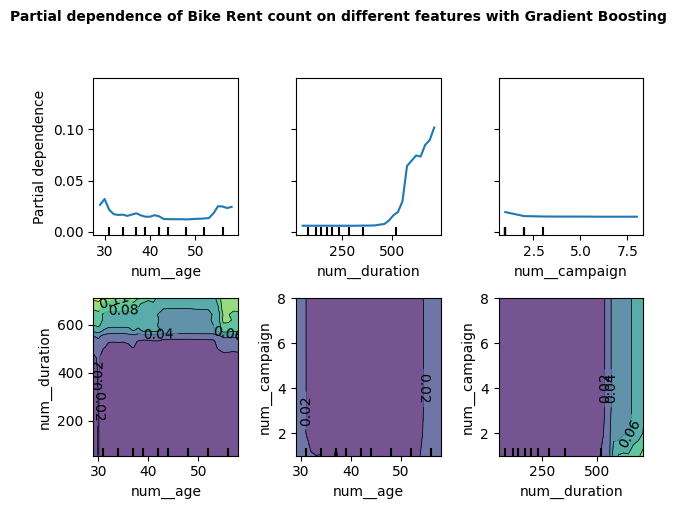

In [13]:
# Create the partial dependence display
pdp = PartialDependenceDisplay.from_estimator(model, 
                                              X_train, 
                                              features = ["num__age", "num__duration", "num__campaign", 
                                                          ("num__age", "num__duration"), ("num__age", "num__campaign"), ("num__duration", "num__campaign")], 
                                              #kind="both", 
                                              grid_resolution=30)

# Adjust the subplots spacing
pdp.figure_.subplots_adjust(wspace=0.4, hspace=0.4)

# Set the suptitle
plt.suptitle("Partial dependence of Bike Rent count on different features with Gradient Boosting", y=1.05, fontsize=10, fontweight='bold')

# Tighten the layout
plt.tight_layout()

# Lime para datos tabulares

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime import lime_tabular

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Entrenar el clasificador (Igual que antes)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train.values, y_train)

# 2. Configurar el Explainer
# NOTA: En class_names es mejor poner los nombres reales de las etiquetas, 
# por ejemplo: ['Benigno', 'Maligno'] o ['No Compra', 'Compra'].
# Aquí uso 'Clase 0' y 'Clase 1' como genéricos.
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Clase 0', 'Clase 1'], 
    mode='classification'
)

# 3. Seleccionar las 5 instancias (pueden ser las primeras 5 o aleatorias)
# Aquí elegimos las primeras 5 del conjunto de test
indices_a_explicar = [0, 1, 2, 3, 4] 

print(f"--- Generando explicaciones LIME para {len(indices_a_explicar)} instancias ---\n")

# 4. Bucle para generar y mostrar cada explicación
for i in indices_a_explicar:
    instance = X_test.iloc[i]
    instance_values = instance.values
    
    # Predecir probabilidades para mostrar en consola
    probs = clf.predict_proba(instance_values.reshape(1, -1))[0]
    pred_class = np.argmax(probs)
    
    print(f"Instancia #{i}")
    print(f"Probabilidades: Clase 0: {probs[0]:.2f}, Clase 1: {probs[1]:.2f}")
    print(f"Predicción del modelo: Clase {pred_class}")
    
    # Generar la explicación
    # num_features=10 mostrará las 10 variables más influyentes para esta decisión
    exp = explainer.explain_instance(
        instance_values, 
        clf.predict_proba, 
        num_features=5
    )
    
    # OPCIÓN A: Si estás en Jupyter Notebook, esto mostrará el gráfico interactivo
    exp.show_in_notebook(show_table=True, show_all=False)
    
    # OPCIÓN B: Si prefieres gráficos estáticos (matplotlib) descomenta la línea de abajo:
    # exp.as_pyplot_figure()
    # plt.show()
    
    print("-" * 50) # Separador visual

--- Generando explicaciones LIME para 5 instancias ---

Instancia #0
Probabilidades: Clase 0: 1.00, Clase 1: 0.00
Predicción del modelo: Clase 0


--------------------------------------------------
Instancia #1
Probabilidades: Clase 0: 0.97, Clase 1: 0.03
Predicción del modelo: Clase 0


--------------------------------------------------
Instancia #2
Probabilidades: Clase 0: 0.99, Clase 1: 0.01
Predicción del modelo: Clase 0


--------------------------------------------------
Instancia #3
Probabilidades: Clase 0: 1.00, Clase 1: 0.00
Predicción del modelo: Clase 0


--------------------------------------------------
Instancia #4
Probabilidades: Clase 0: 1.00, Clase 1: 0.00
Predicción del modelo: Clase 0


--------------------------------------------------


# SHAP

In [104]:
! pip install shap

   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 4.5 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   

In [106]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[i,:,0], X_test.iloc[i].values, feature_names=X.columns)



In [108]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[i,:,1], X_test.iloc[i].values, feature_names=X.columns)

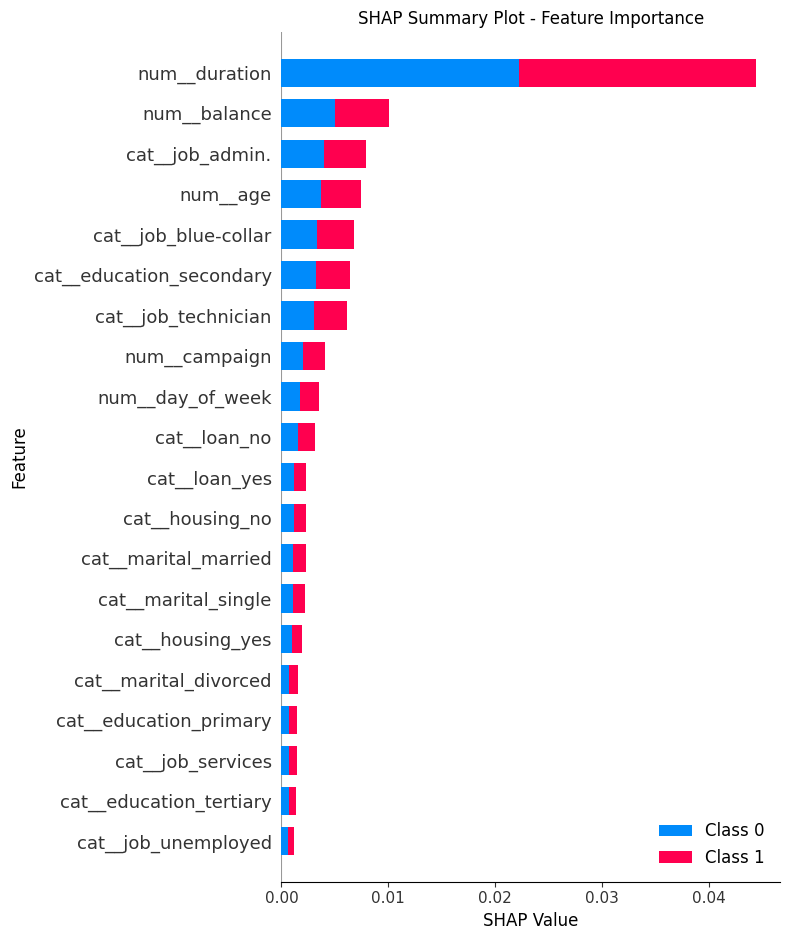

In [110]:
# Create a summary plot with the bar plot type
shap_values = explainer.shap_values(X_train)

# Bug en paquete shap, setiembre 2024
ensured_list_shap_values = [shap_values[:,:,i] for i in range(shap_values.shape[2])]
shap.summary_plot(ensured_list_shap_values, X_train, plot_type='bar', show=False)

# explainer = shap.Explainer(clf)
# shap_values = explainer(X_test)
# ax = shap.plots.bar(shap_values[:,:,0],show=False)


# Customize the plot appearance
plt.title("SHAP Summary Plot - Feature Importance")
plt.xlabel("SHAP Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [111]:
explainer_a = shap.Explainer(clf)
shap_values_cat = explainer_a(X_test)

In [112]:
shap_values_cat.shape

(200, 51, 2)

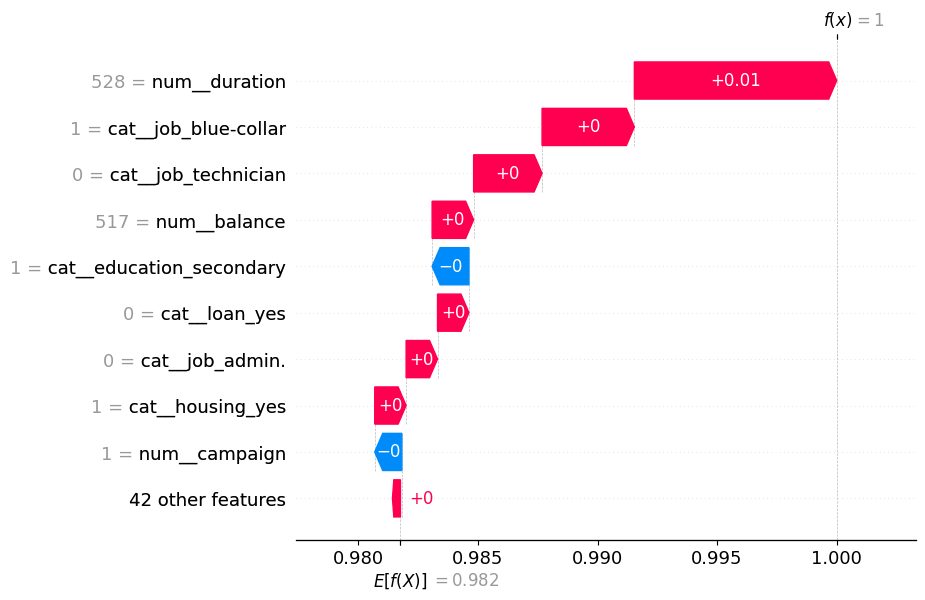

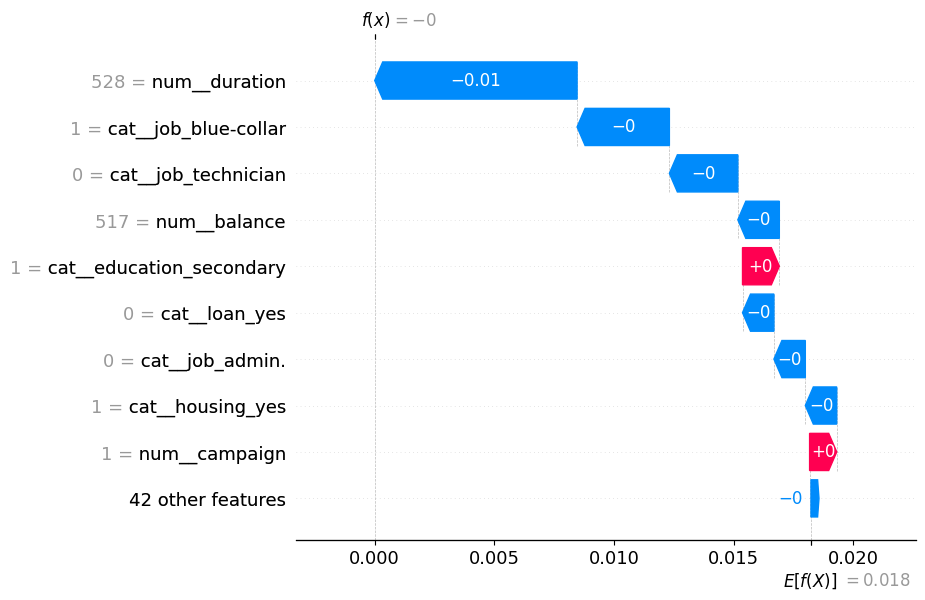

In [114]:
shap.plots.waterfall(shap_values_cat[i,:,0])
shap.plots.waterfall(shap_values_cat[i,:,1])